# One-shot multi-step LSTM Model on Lab p4581
Author: Camilla Billari <br> 
Date: 26/01/24

Fitting a one-shot multi-step LSTM to the Marone p4581 experiment.

In [2]:
# Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import tqdm

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset

In [8]:
# Check if CUDA (NVIDIA GPU acceleration) is available
if torch.cuda.is_available():
    dev, map_location = "cuda", None  # Use GPU
    print(
        f"Total GPUs available: {torch.cuda.device_count()}"
    )  # Display GPU count
    !nvidia-smi  # Display GPU details using nvidia-smi
else:
    dev, map_location = "cpu", "cpu"  # Use CPU
    print("No GPU available.")

# Set PyTorch device based on the chosen device (cuda or cpu)
device = torch.device(dev)

No GPU available.


## Load Data

In [9]:
# Access experiment and output dataframe head using Pritt's data loaders (which utilises Adriano's loading + pre-processing)
EXP = "p4581"
dataset = SlowEarthquakeDataset([EXP])
dataset.load()

# Extract optupts (X, Y, t)
ds_exp = dataset[EXP]
X, Y, t = ds_exp["X"], ds_exp["Y"], ds_exp["t"]

# Create dataframe from outputs
df = pd.DataFrame(
    np.hstack((X, Y, t.reshape(-1, 1))),
    columns=[ds_exp["hdrs"]["X"], *ds_exp["hdrs"]["Y"], ds_exp["hdrs"]["t"]],
)

print("N samples: {}".format(len(df)))
df.head()

N samples: 200010


,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,1.29911,2.99288,NaN,NaN,0.000
1,1.29903,2.99008,NaN,NaN,0.001
2,1.29853,2.98854,NaN,NaN,0.002
3,1.29871,2.98849,NaN,NaN,0.003
4,1.29854,2.99069,NaN,NaN,0.004


In [10]:
df = df.dropna(axis=1)

### Downsampling

In [11]:
ds_factor = 1e2

downsampled_df = (
    df.rolling(window=int(ds_factor), step=int(ds_factor)).mean().dropna()
)
downsampled_df = downsampled_df.reset_index(drop=True)
downsampled_df = downsampled_df.dropna()
print("N downsampled samples: {}".format(len(downsampled_df)))
downsampled_df.head()

N downsampled samples: 2000


,obs_shear_stress,obs_normal_stress,time
0,1.299621,2.989553,0.050500
1,1.301409,2.989707,0.150501
2,1.303105,2.989653,0.250501
3,1.304593,2.989767,0.350502
4,1.306144,2.989687,0.450502


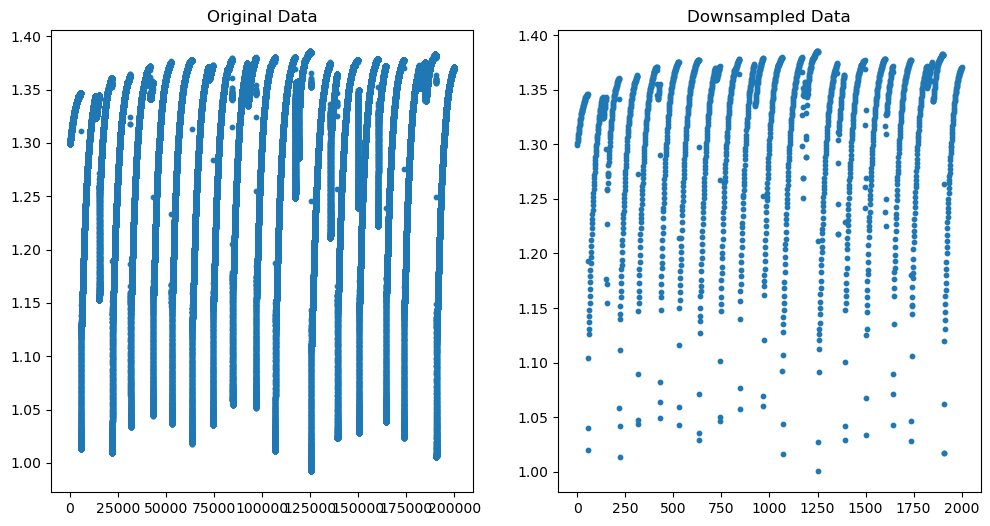

In [12]:
# Plot relevant features in the original and downsampled datasets
plt.figure(figsize=(12, 6))

# Example: Plotting the first feature in the dataset
plt.subplot(1, 2, 1)
plt.scatter(
    range(len(df)), df["obs_shear_stress"], label="Original Data", s=10
)
# plt.plot(df["obs_shear_stress"])
plt.title("Original Data")

plt.subplot(1, 2, 2)
plt.scatter(
    range(len(downsampled_df)),
    downsampled_df["obs_shear_stress"],
    label="Downsampled Data",
    s=10,
)
# plt.plot(downsampled_df["obs_shear_stress"])
plt.title("Downsampled Data")

plt.show()

In [13]:
# Display summary statistics for relevant features
print("Original Data Statistics:")
print(df["obs_shear_stress"].describe())

print("\nDownsampled Data Statistics:")
print(downsampled_df["obs_shear_stress"].describe())

Original Data Statistics:
count    200010.000000
mean          1.309420
std           0.073835
min           0.992148
25%           1.279090
50%           1.338025
75%           1.362330
max           1.385850
Name: obs_shear_stress, dtype: float64

Downsampled Data Statistics:
count    2000.000000
mean        1.309417
std         0.073125
min         1.000536
25%         1.278529
50%         1.337485
75%         1.362227
max         1.385181
Name: obs_shear_stress, dtype: float64


In [14]:
from scipy.stats import f_oneway, ttest_ind

# Assuming you want to compare the mean and variance of a specific feature (e.g., "obs_shear_stress")
original_feature = df["obs_shear_stress"]
downsampled_feature = downsampled_df["obs_shear_stress"]

# Perform two-sample t-test for mean comparison
t_statistic_mean, p_value_mean = ttest_ind(
    original_feature, downsampled_feature
)

# Perform F-test for variance comparison
f_statistic, p_value_variance = f_oneway(original_feature, downsampled_feature)

# Print results for mean comparison
print("Mean Comparison:")
print("t-statistic:", t_statistic_mean)
print("p-value:", p_value_mean)

# Print results for variance comparison
print("\nVariance Comparison:")
print("F-statistic:", f_statistic)
print("p-value:", p_value_variance)

# Check if the p-values are below a significance level (e.g., 0.05)
if p_value_mean < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("There is no significant difference in means.")

if p_value_variance < 0.05:
    print("The difference in variances is statistically significant.")
else:
    print("There is no significant difference in variances.")

Mean Comparison:
t-statistic: 0.0016292346874460305
p-value: 0.9987000609808329

Variance Comparison:
F-statistic: 2.654405666609999e-06
p-value: 0.998700058313535
There is no significant difference in means.
There is no significant difference in variances.


## Creating the datastet

In [15]:
def create_dataset(dataset, lookback, forecast):
    """Transform a time series into a prediction dataset

    Args:
        dataset: Numpy array of time series (first dimension is the time steps).
        lookback: Size of the window for prediction.
        forecast: Number of time steps to predict into the future.
    Return:
        X_tensor: Pytorch tensor of the X windowed features
        y_tensor: Pytorch tensor of the y windowed targets
    """
    X, y = [], []

    # Create input features (X) and corresponding targets (y) for prediction
    for i in range(len(dataset) - lookback - forecast + 1):
        feature = dataset[i : i + lookback]
        target = dataset[i + lookback : i + lookback + forecast]
        X.append(feature)
        y.append(target)

    # Convert the lists to PyTorch tensors - note list->arrays->tensors is faster than list->tensors
    return torch.from_numpy(np.array(X, dtype=np.float32)), torch.from_numpy(
        np.array(y, dtype=np.float32)
    )

In [16]:
# Create a seed for the dataset and model
SEED = 17

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [17]:
# Extract time series data
timeseries = downsampled_df["obs_shear_stress"]
# timeseries = denoised_df

# Define lookback and forecast values
LOOKBACK, FORECAST = 40, 20

# Create X & Y dataset
X, y = create_dataset(timeseries, LOOKBACK, FORECAST)

In [18]:
N_FORECAST_WINDOWS = 15
test_size = N_FORECAST_WINDOWS * FORECAST
excess = X[:-test_size].shape[0] - FORECAST * (
    X[:-test_size].shape[0] // FORECAST
)

X_test, y_test = X[-test_size:], y[-test_size:]
X_train, y_train = X[excess:-test_size], y[excess:-test_size]


# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([1640, 40]), torch.Size([1640, 20])
Testing data shapes: torch.Size([300, 40]), torch.Size([300, 20])


### Normalising with scaler based on the training set

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Note - we should only fit the scaler to the training set, not the test set!! Super important
# We only transform the test set, and we will then do an inverse transform later when evaluating.
X_train_sc, X_test_sc = scaler_X.fit_transform(X_train), scaler_X.transform(
    X_test
)
y_train_sc, y_test_sc = scaler_y.fit_transform(y_train), scaler_y.transform(
    y_test
)

# Turn all scaled arrays into float tensors
X_train_sc, X_test_sc = (
    torch.from_numpy(X_train_sc).float(),
    torch.from_numpy(X_test_sc).float(),
)
y_train_sc, y_test_sc = (
    torch.from_numpy(y_train_sc).float(),
    torch.from_numpy(y_test_sc).float(),
)

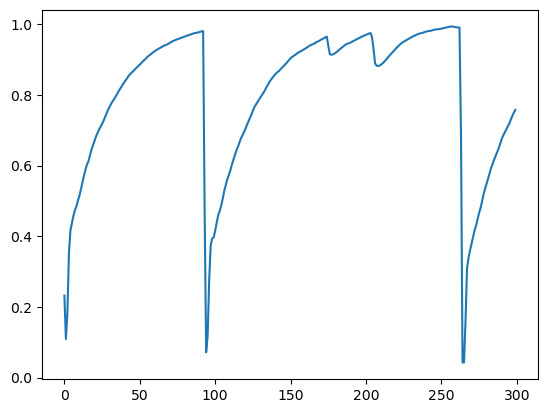

In [20]:
# Plot 3rd X_test window
plt.plot(X_test_sc[:, 2])

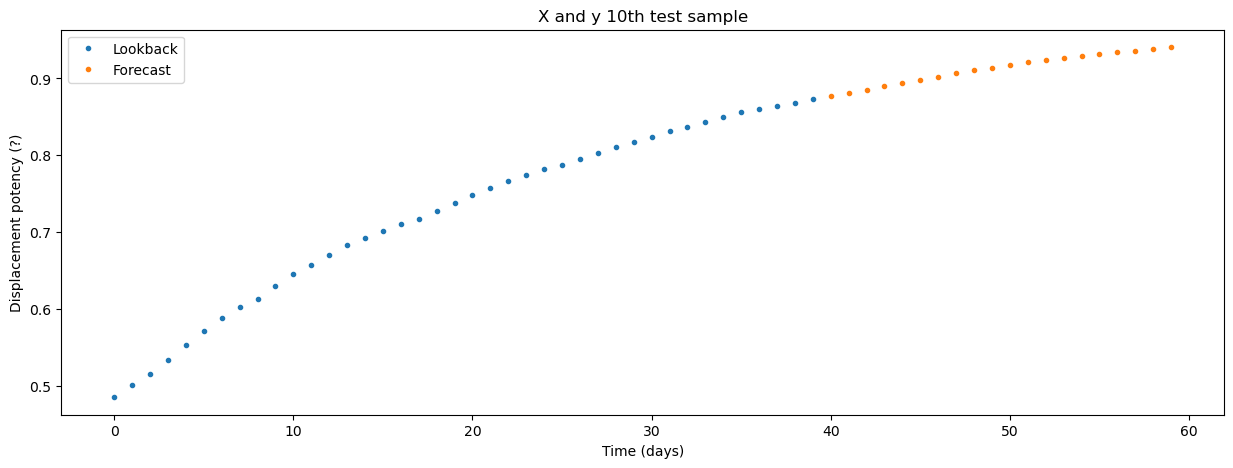

In [21]:
# Plot an example X and y sample
plt.figure(figsize=(15, 5))
plt.plot(X_test_sc[10], ".", label="Lookback")
# Plot the y sample shifted by the length of the lookback
plt.plot(np.arange(LOOKBACK, LOOKBACK + FORECAST), y_test_sc[10], ".", label="Forecast")
plt.title("X and y 10th test sample")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

## Modelling

In [22]:
import torch.nn as nn


class MultiStepLSTM(nn.Module):
    """Subclass of nn.Module"""

    def __init__(
        self, n_variates=1, hidden_size=50, n_layers=1, output_size=FORECAST
    ):
        super().__init__()
        self.n_variates = n_variates
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size

        # LSTM layer with specified input size, hidden size, and batch_first
        self.lstm = nn.LSTM(
            input_size=self.n_variates,
            hidden_size=self.hidden_size,
            num_layers=self.n_layers,
            batch_first=True,
        )

        # Linear layer mapping the LSTM output to the forecasted values
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        """Forward pass through the LSTM layer."""
        # Initialise hidden state and cell state
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(device)

        # LSTM layer
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Extract the last time step output from the LSTM output
        lstm_out = lstm_out[:, -1, :]

        # Linear layer for the final output (forecasted values)
        output = self.linear(lstm_out)

        return output

### Training

In [23]:
# Move training and testing data to the specified device (cuda or cpu)
X_train_sc = X_train_sc.to(device)
y_train_sc = y_train_sc.to(device)
X_test_sc = X_test_sc.to(device)
y_test_sc = y_test_sc.to(device)

In [24]:
import torch.optim as optim
import torch.utils.data as data
from sklearn.metrics import r2_score

# Define the number of input variates and hidden size
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

# Instantiate the AirModel and move it to the specified device
model = MultiStepLSTM(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE).to(
    device
)

# Define Adam optimizer and Mean Squared Error (MSE) loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Create a DataLoader for training batches
loader = data.DataLoader(
    data.TensorDataset(X_train_sc, y_train_sc), shuffle=True, batch_size=32
)

# Set the number of training epochs
n_epochs = 100
pbar = tqdm.tqdm(range(n_epochs))

# Lists to store RMSE values for plotting
train_rmse_list = []
test_rmse_list = []

# Training loop
for epoch in pbar:
    model.train()

    # Iterate through batches in the DataLoader
    for X_batch, y_batch in loader:
        # Reshape input for univariate (add a dimension) and model
        y_pred = model(X_batch.unsqueeze(-1))
        loss = loss_fn(y_pred, y_batch)

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()

    with torch.no_grad():  # do not consider gradient in evaluating - no backprop
        # Evaluate model on training data
        y_train_pred = model(X_train_sc.unsqueeze(-1))
        y_train_pred = torch.Tensor(
            scaler_y.inverse_transform(y_train_pred.cpu())
        )
        train_rmse = np.sqrt(loss_fn(y_train_pred, y_train))
        train_rmse_list.append(train_rmse.item())
        train_r2 = r2_score(y_train, y_train_pred)

        # Evaluate model on testing data
        y_test_pred = model(X_test_sc.unsqueeze(-1))
        y_test_pred = torch.Tensor(
            scaler_y.inverse_transform(y_test_pred.cpu())
        )
        test_rmse = np.sqrt(loss_fn(y_test_pred, y_test))
        test_rmse_list.append(test_rmse.item())
        test_r2 = r2_score(y_test, y_test_pred)

    # Update progress bar with training and testing RMSE
    pbar.set_description(
        f"Epoch [{epoch+1}/{n_epochs}], Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}, Last Batch Loss: {loss.item():.4f}"
    )

Epoch [100/100], Train RMSE: 0.0589, Test RMSE: 0.0542, Train R2: 0.3652, Test R2: 0.4456, Last Batch Loss: 0.0133: 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


## Results

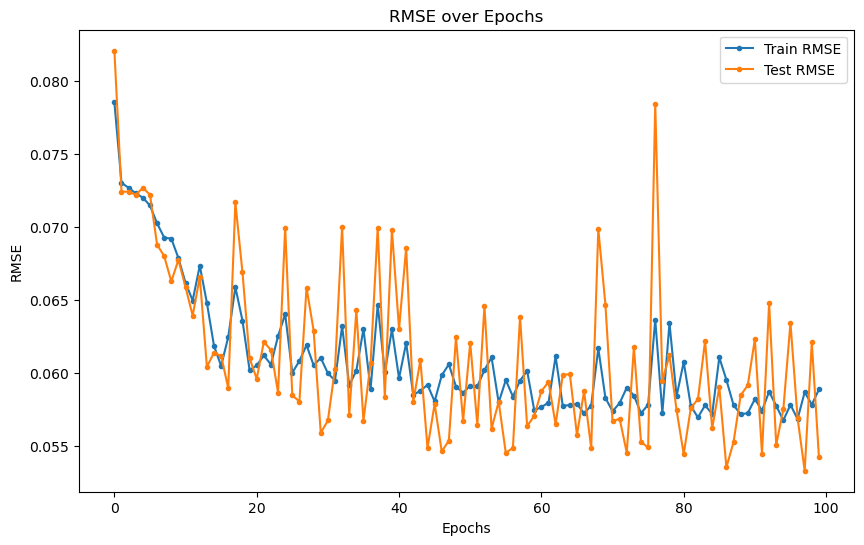

In [25]:
# Plot RMSE over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(0, n_epochs), train_rmse_list, label="Train RMSE", marker=".")
plt.plot(range(0, n_epochs), test_rmse_list, label="Test RMSE", marker=".")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

In [26]:
with torch.no_grad():
    train_outputs = scaler_y.inverse_transform(
        model(X_train_sc.unsqueeze(-1)).cpu().numpy()
    )
    test_outputs = y_test_pred

train_plot = np.array(
    [train_outputs[idx] for idx in range(0, len(train_outputs), FORECAST)]
).reshape(-1, 1)

test_plot = np.array(
    [test_outputs[idx] for idx in range(0, len(test_outputs), FORECAST)]
).reshape(-1, 1)

combined_plot = np.concatenate((train_plot, test_plot))

test_start_index = len(timeseries) - len(y_test) - LOOKBACK

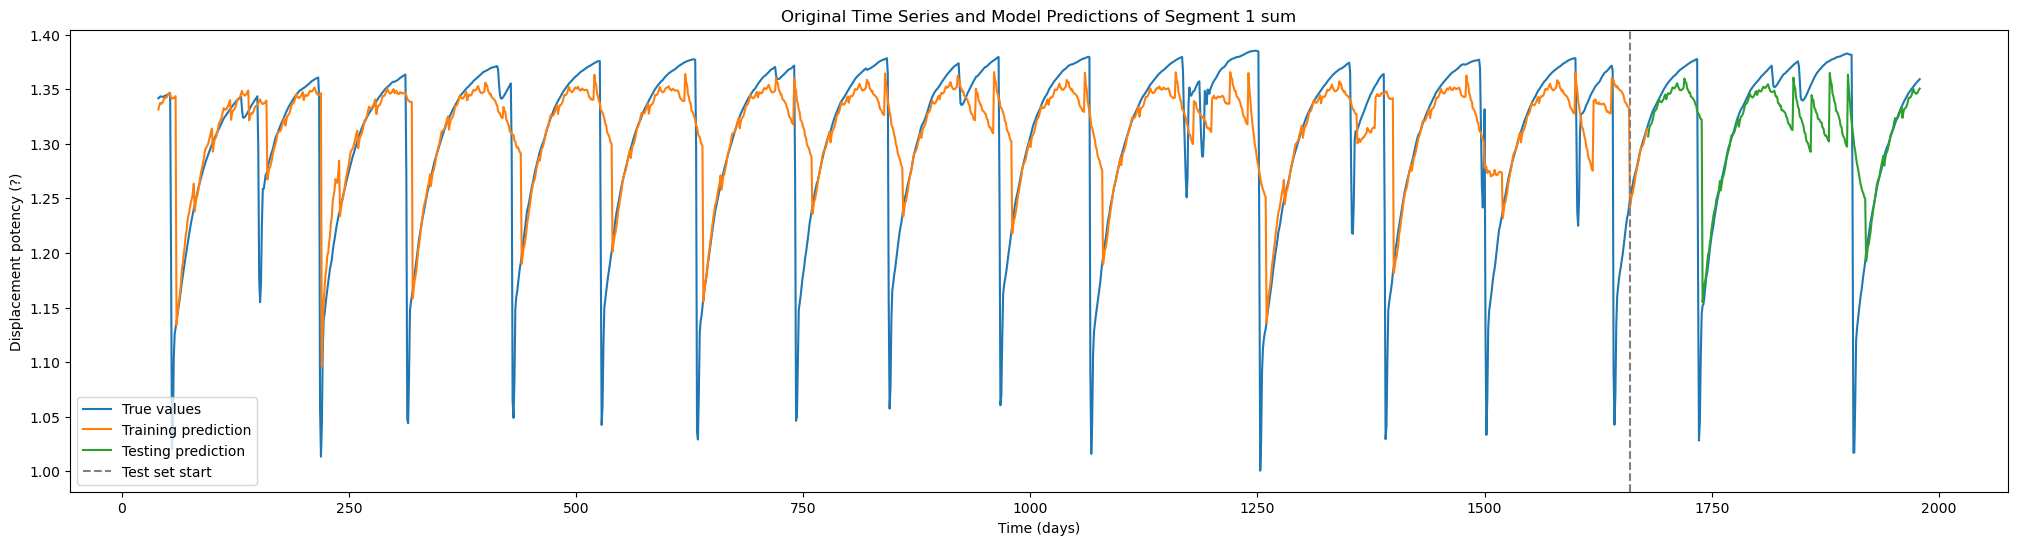

In [27]:
plt.figure(figsize=(25, 6))
plt.plot(
    range(LOOKBACK, LOOKBACK + len(combined_plot)),
    np.concatenate((y_train[:, 0], y_test[:, 0])),
    label="True values",
)

plt.plot(
    range(LOOKBACK, LOOKBACK + len(train_plot)),
    train_plot,
    label="Training prediction",
)
plt.plot(
    range(LOOKBACK + len(train_plot), LOOKBACK + len(combined_plot)),
    test_plot,
    label="Testing prediction",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.title("Original Time Series and Model Predictions of Segment 1 sum")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()

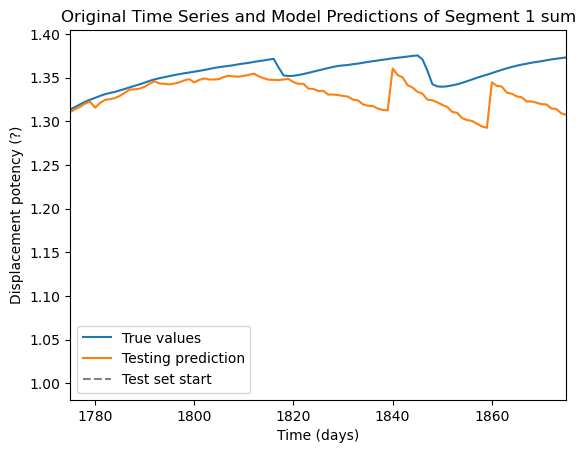

In [28]:
plt.plot(
    range(LOOKBACK, LOOKBACK + len(combined_plot)),
    np.concatenate((y_train[:, 0], y_test[:, 0])),
    label="True values",
)
plt.plot(
    range(LOOKBACK + len(train_plot), LOOKBACK + len(combined_plot)),
    test_plot,
    label="Testing prediction",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)

# Set x-axis limits to focus on the time range 3400-3500
plt.xlim(1775, 1875)
plt.title("Original Time Series and Model Predictions of Segment 1 sum")
plt.xlabel("Time (days)")
plt.ylabel("Displacement potency (?)")
plt.legend()
plt.show()